In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import torch.nn.functional as F

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from linear_models import ftr_transform, max_ftr_transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [3]:
# wavelet params
waves = ["db5"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [6]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT1d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            dic['index'][(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)

            dic['wt'][(r,c)] = wt
            dic['psi'][(r,c)] = psi     
            dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
            dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# calculate accuracy

In [27]:
wt = dic['wt'][(3,10)]
wt_o

DWT1d()

In [59]:
h0 = wt.h0
h1 = low_to_high(h0)
h1 = h1[...,5:]

In [46]:
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

In [122]:
data = iter(test_loader).next()[0].to(device)

In [109]:
h1 = h1.cpu()

In [117]:
X = []
y = []
scales = [1,2,3,4,5,6]
for data, labels in train_loader:
    for s in scales:
        filt = F.interpolate(h1, scale_factor=s, mode='linear')
        data_t = F.conv1d(data, filt, padding=5)
        a = deepcopy(torch.max(data_t.detach(), dim=2)[0])
        b = deepcopy(-torch.max(-data_t.detach(), dim=2)[0])
        f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
        x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f        
        if s == 1:
            x = x1[:,None]
        else:
            x = torch.cat((x,x1[:,None]), axis=1)
    X.append(x)
    y.append(labels)
X = torch.cat(X).squeeze().numpy()
y = torch.cat(y).squeeze().numpy()

X_test = []
y_test = []
scales = [1,2,3,4,5,6]
for data, labels in test_loader:
    for s in scales:
        filt = F.interpolate(h1, scale_factor=s, mode='linear')
        data_t = F.conv1d(data, filt, padding=5)
        a = deepcopy(torch.max(data_t.detach(), dim=2)[0])
        b = deepcopy(-torch.max(-data_t.detach(), dim=2)[0])
        f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
        x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f        
        if s == 1:
            x = x1[:,None]
        else:
            x = torch.cat((x,x1[:,None]), axis=1)        
    X_test.append(x)
    y_test.append(labels)
X_test = torch.cat(X_test).squeeze().numpy()
y_test = torch.cat(y_test).squeeze().numpy()   

In [118]:
clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
error = metrics.r2_score(y_test, preds)
print(error)

0.04213428092470728


In [143]:
filt = F.interpolate(h1, scale_factor=1, mode='linear')
data_t = F.conv1d(data, filt, padding=5)
a = deepcopy(torch.max(data_t.detach(), dim=2)[0])
b = deepcopy(-torch.max(-data_t.detach(), dim=2)[0])

In [145]:
torch.max(-data_t[0])

tensor(1.7074, grad_fn=<MaxBackward1>)

In [148]:
torch.max(abs(data_t[0]))

tensor(1.7074, grad_fn=<MaxBackward1>)

In [ ]:
a = deepcopy(torch.max(data_t.detach(), dim=2)[0])
b = deepcopy(-torch.max(-data_t.detach(), dim=2)[0])
f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f        
if s == 1:
    x = x1[:,None]
else:
    x = torch.cat((x,x1[:,None]), axis=1)

In [128]:
data=data.to('cpu')

In [158]:
filt = F.interpolate(h1, scale_factor=2, mode='linear')
data_t = F.conv1d(data, filt, padding=5)

In [159]:
torch.max(abs(data_t[2,0]))

tensor(0.4275, grad_fn=<MaxBackward1>)

In [157]:
X_test[2]

array([0.43794173, 0.42746347, 0.6568997 , 0.6707241 , 0.7213828 ,
       0.68552   ], dtype=float32)

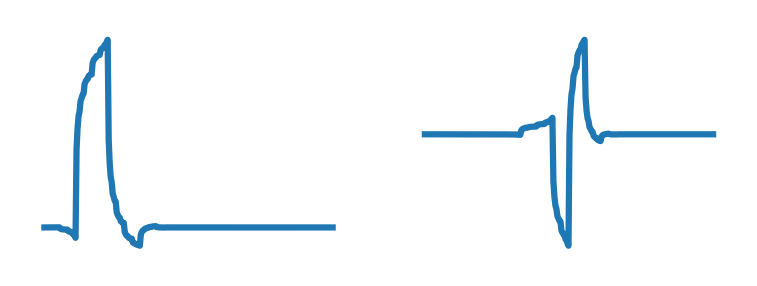

In [26]:
def max_ftr_transform(w_transform, train_loader, test_loader):
    w_transform = w_transform.to('cpu')
    J = w_transform.J
    X = []
    y = []
    for data, labels in train_loader:
        data_t = w_transform(data)
        for j in range(1):
            a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])
            f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
            x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f                        
            if j == 0:
                x = x1[:,None]
            else:
                x = torch.cat((x,x1[:,None]), axis=1)
        X.append(x)
        y.append(labels)
    X = torch.cat(X).squeeze().numpy()
    y = torch.cat(y).squeeze().numpy()

    X_test = []
    y_test = []
    for data, labels in test_loader:
        data_t = w_transform(data)
        for j in range(1):
            a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])
            f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
            x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f            
            if j == 0:
                x = x1[:,None]
            else:
                x = torch.cat((x,x1[:,None]), axis=1)
        X_test.append(x)
        y_test.append(labels)
    X_test = torch.cat(X_test).squeeze().numpy()
    y_test = torch.cat(y_test).squeeze().numpy()   
    
    return (X, y), (X_test, y_test)  

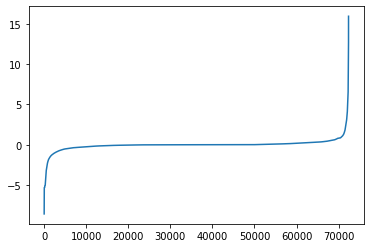

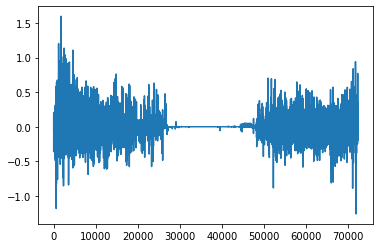

In [160]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=False)   

model = load_pretrained_model(p.model_path, device=device)  

# define trim model
mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

reps = torch.tensor([]).to(device)
attr = torch.tensor([]).to(device)

for data, _ in test_loader:
    data = data.to(device)
    data_t = wt(data)
    with torch.backends.cudnn.flags(enabled=False):
        attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    reps = torch.cat((reps, y), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    attr = torch.cat((attr, z), dim=0)
reps = reps.reshape(-1)
attr = attr.reshape(-1)    

sort_indexes = torch.argsort(reps, dim=0, descending=False)    

plt.plot(reps[sort_indexes].detach().cpu())
plt.show()

plt.plot(attr[sort_indexes].detach().cpu())
plt.show()

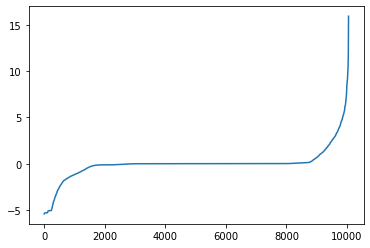

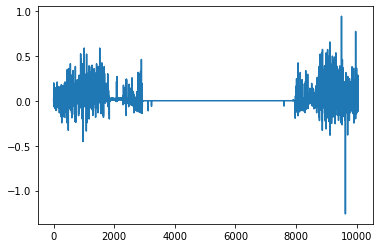

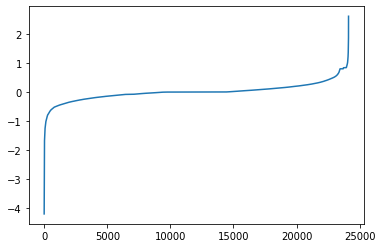

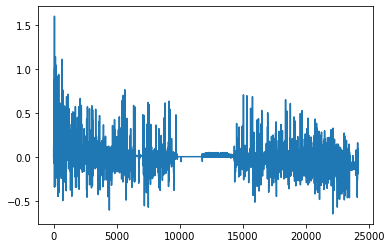

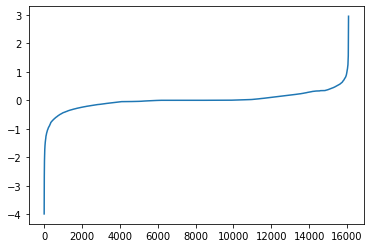

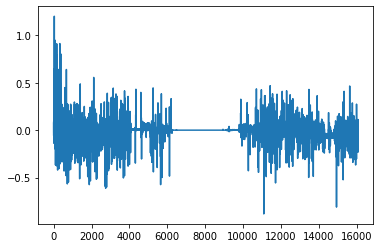

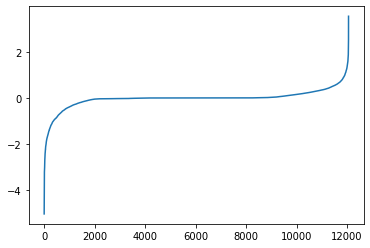

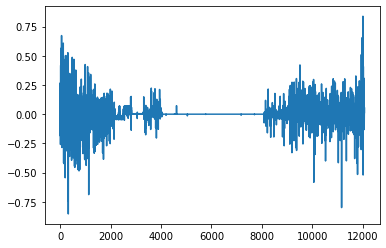

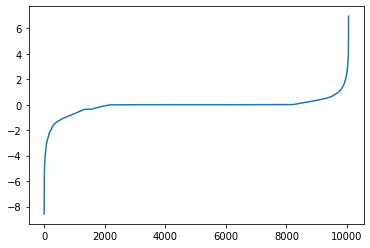

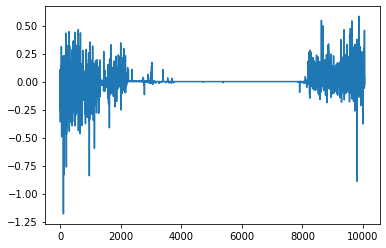

In [172]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=False)   

model = load_pretrained_model(p.model_path, device=device)  

# define trim model
mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

for j in range(5):
    
    reps = torch.tensor([]).to(device)
    attr = torch.tensor([]).to(device)

    for data, _ in test_loader:
        data = data.to(device)
        data_t = wt(data)
        with torch.backends.cudnn.flags(enabled=False):
            attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    #     y, _ = tuple_to_tensor(data_t)
        y = data_t[j].squeeze()
        reps = torch.cat((reps, y), dim=0)     
    #     z, _ = tuple_to_tensor(attributions)
        z = attributions[j].squeeze()
        attr = torch.cat((attr, z), dim=0)
    reps = reps.reshape(-1)
    attr = attr.reshape(-1)    

    sort_indexes = torch.argsort(reps, dim=0, descending=False)    

    plt.plot(reps[sort_indexes].detach().cpu())
    plt.show()

    plt.plot(attr[sort_indexes].detach().cpu())
    plt.show()